In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('train.txt', sep=' ', names=['word', 'tag', 'ignore'])
train.drop(['ignore'], axis=1, inplace=True)
train['prev_tag'] = train['tag'].shift(1)

train

,word,tag,prev_tag
0,Confidence,NN,NaN
1,in,IN,NN
2,the,DT,IN
3,pound,NN,DT
4,is,VBZ,NN
...,...,...,...
211722,to,TO,PRP
211723,San,NNP,TO
211724,Francisco,NNP,NNP
211725,instead,RB,NNP


In [3]:
test = pd.read_csv('test.txt', sep=' ', names=['word', 'tag', 'ignore'])
test.drop(['ignore'], axis=1, inplace=True)

### Initial EDA

# of unique words: 19122
# of unique tags: 44


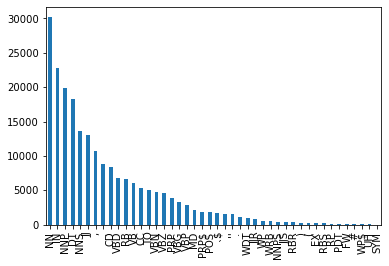

In [4]:
#train data
print('# of unique words:', train['word'].nunique())
print('# of unique tags:', train['tag'].nunique())

train_tag = train['tag'].value_counts().plot(kind='bar')

# of unique words: 8118
# of unique tags: 43


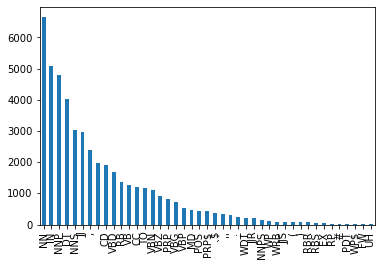

In [5]:
# test data
print('# of unique words:', test['word'].nunique())
print('# of unique tags:', test['tag'].nunique())

test_tag = test['tag'].value_counts().plot(kind='bar')

In [6]:
print(train.groupby('word')['word'].count().nlargest(10))
test.groupby('word')['word'].count().nlargest(10)

word
,      10770
the     9219
.       8725
of      5201
to      5045
a       4295
and     3578
in      3398
's      1914
for     1857
Name: word, dtype: int64


word
,      2390
the    2059
.      1952
to     1174
of     1119
a       919
and     827
in      746
's      429
for     414
Name: word, dtype: int64

### Probability Functions

In [7]:
wt = list(zip(train['word'], train['tag']))
tt = list(zip(train['tag'], train['prev_tag']))

wt_count = Counter(wt)
tt_count = Counter(tt)

tag_count = Counter(train['tag'])

In [8]:
def Pt(t=''):
    return tag_count[t]/len(train)

# check if sum to 1
np.sum([Pt(t=x) for x in tag_count])

0.9999999999999999

In [9]:
def Pwt(w='', t=''):
    return wt_count[w,t]/len(train)

def Ptt(t1='', t2=''):
    return tt_count[t1,t2]/len(train)

# check if sum to 1
print(np.sum([Pwt(w=i, t=j) for i,j in set(wt_count)]))
np.sum([Ptt(t1=i, t2=j) for i,j in set(tt_count)])

1.0


1.0

In [10]:
def CPwt(w='', t=''):
    p = Pwt(w=w, t=t)/Pt(t=t)
    if p == 0:
        return .000001
    return p

def CPtt(t1='', t2=''):
    p = Ptt(t1=t1, t2=t2)/Pt(t=t2)
    if p == 0:
        return .000001
    return p

In [11]:
def emission(w):
    return [[t,CPwt(w=w,t=t)] for t in set(train['tag'])]

In [12]:
def transition(t):
    return [[c, CPtt(t1=c, t2=t)] for c in set(train['tag'])]

### Greedy HMM

In [13]:
test

,word,tag
0,Rockwell,NNP
1,International,NNP
2,Corp.,NNP
3,'s,POS
4,Tulsa,NNP
...,...,...
47372,according,VBG
47373,to,TO
47374,Mr.,NNP
47375,Harlow,NNP


In [14]:
# tags list to store predicted POS tag
tags = []
words = list(test['word'])

In [15]:
t = max(emission(words[0]))
t

['``', 1e-06]

In [16]:
# initial tag
tags.append(t[0])
tags

['``']

In [17]:
# loop appends the max of the transition*emission for each tag
for i in range(1,len(words)):
    tlist = transition(tags[i-1])
    elist = emission(words[i])
    clist = [(t[0], t[1]*e[1]) for t,e in zip(tlist,elist)]
    tags.append(max(clist, key=lambda x:x[1])[0])

### Accuracy

In [18]:
# creates new column based on tags list and compares the prediction with actual
test['prediction'] = tags
test['correct'] = np.where(test['tag'] == test['prediction'], 1, 0)

In [19]:
print('accuracy:', '{}%'.format(test['correct'].sum()/len(test)*100))

accuracy: 92.55334867129619%


In [20]:
test

,word,tag,prediction,correct
0,Rockwell,NNP,``,0
1,International,NNP,NNP,1
2,Corp.,NNP,NNP,1
3,'s,POS,POS,1
4,Tulsa,NNP,NNP,1
...,...,...,...,...
47372,according,VBG,VBG,1
47373,to,TO,TO,1
47374,Mr.,NNP,NNP,1
47375,Harlow,NNP,NNP,1


### Confusion Matrix

In [21]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(test['tag'], test['prediction'], labels=list(set(test['tag'])))

In [22]:
np.set_printoptions(threshold=np.inf)
print(c)

[[ 115    0    0    0    3    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
    84]
 [   0 2443    0    0  143    0    0    0    0    0    0    8    1    0
     0    0  226    0    0    5    0    0   67    0    0    0    0    5
     0    0   28    0    0    0    0    0    0    0    0    0    0    0
    38]
 [   0    1   35    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0   35
     0]
 [   0    0    0    4    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   2    0    0    0 3997    0    0    1    0    0    0    0    0    0
     0    0    0    0    0    0 

In [23]:
# tag, correct, sum for each tag's confusion matrix
labels = list(set(test['tag']))
for i,j in enumerate(c):
    print(i, labels[i], c[i][i]/sum(c[i]), sum(c[i]))

0 WDT 0.5693069306930693 202
1 JJ 0.8242240215924427 2964
2 RBR 0.49295774647887325 71
3 WP$ 1.0 4
4 DT 0.9942786069651741 4020
5 POS 0.9078341013824884 434
6 '' 0.9936708860759493 316
7 PDT 0.4 10
8 VBP 0.8256029684601113 539
9 TO 1.0 1178
10 RP 0.4166666666666667 12
11 PRP 0.9987714987714987 814
12 VBZ 0.9079956188389924 913
13 FW 0.75 4
14 $ 1.0 384
15 ) 1.0 77
16 NN 0.9302920806985847 6642
17 WP 1.0 110
18 UH 0.5 2
19 CD 0.9202294056308655 1918
20 . 1.0 1975
21 EX 1.0 48
22 NNP 0.8564294631710362 4806
23 ( 0.987012987012987 77
24 RBS 0.9795918367346939 49
25 VBN 0.8061594202898551 1104
26 PRP$ 0.997624703087886 421
27 VB 0.9125295508274232 1269
28 : 0.9957983193277311 238
29 # 1.0 11
30 RB 0.8766617429837519 1354
31 CC 0.9975288303130149 1214
32 , 0.999581589958159 2390
33 `` 1.0 323
34 VBD 0.9047051816557474 1679
35 NNS 0.8734344100197758 3034
36 VBG 0.8118131868131868 728
37 MD 0.9893617021276596 470
38 WRB 0.989247311827957 93
39 NNPS 0.5846153846153846 130
40 JJS 0.935064935064

### what are some common errors that your tagger makes?
The tagger had low accuracy on the NNPS, PDT, WDT, UH, RP, and RBR tags. Many of the tags that have a low accuracy have small sample sizes, so the tagger does not predict these as much due to a smaller probability of them occuring. There were a few tags such as RBR for example would predict JJR about half of the time. 